In [ ]:
# Get ELENA
!git clone https://github.com/michelelucente/ELENA.git
%cd ELENA

# Install Python deps for notebooks + examples
# (names follow ELENA’s README; CosmoTransitions is on PyPI)
%pip install -q numpy scipy matplotlib cosmoTransitions NatPy la-forge


Cloning into 'ELENA'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 420 (delta 12), reused 9 (delta 2), pack-reused 393 (from 1)
Receiving objects: 100% (420/420), 22.56 MiB | 24.97 MiB/s, done.
Resolving deltas: 100% (270/270), done.
/content/ELENA/ELENA/ELENA


In [ ]:
# Add ELENA/src to the Python path for imports (as suggested by the repo)
import sys, os
sys.path.append(os.path.abspath('src'))

In [ ]:
%%writefile /content/utils.py
import numpy as np

# Simple energy unit conversion dictionary
convert_units = {
    "MeV": 1e-3,  # MeV → GeV
    "GeV": 1.0,   # base unit
    "TeV": 1e3,   # TeV → GeV
}

# Entropy density of the SM plasma (approximate, constant g_star)
g_star_SM = 106.75

def s_SM(T):
    """
    Standard Model entropy density s(T) ≈ (2π^2/45) g_* T^3
    T in the same energy units as the rest of the code (typically GeV).
    """
    T = np.asarray(T, dtype=float)
    return (2.0 * np.pi**2 / 45.0) * g_star_SM * T**3


Overwriting /content/utils.py


In [ ]:
%%writefile /content/ELENA/src/utils.py
import numpy as np

# Simple energy unit conversion dictionary
convert_units = {
    "MeV": 1e-3,  # MeV → GeV
    "GeV": 1.0,   # base unit
    "TeV": 1e3,   # TeV → GeV
}

g_star_SM = 106.75

def s_SM(T):
    """
    Standard Model entropy density s(T) ≈ (2π^2/45) g_* T^3
    T in the same energy units as the rest of the code (typically GeV).
    """
    T = np.asarray(T, dtype=float)
    return (2.0 * np.pi**2 / 45.0) * g_star_SM * T**3


Overwriting /content/ELENA/src/utils.py


In [ ]:
%%writefile potential_3d.py
import numpy as np

# ---------- numerically safe helpers ----------
def _rtabs(x, floor=1e-30):
    """sqrt(|x|) with a tiny floor (keeps logs/ratios finite but preserves cancellations)."""
    return np.sqrt(np.maximum(np.abs(x), floor))

def _logsafe(x):
    return np.log(np.clip(np.abs(x), 1e-30, None))

# ---------- 4D input couplings ----------
g1_4   = 0.54
lam_4  = 1.65e-3
m0sq_4 = -(130.0**2)
Yphi   = 1.0

# ---------- thermal matching (placeholder; swap with DRalgo) ----------
cT   = 0.30*(g1_4**2) + 0.10*lam_4
c_mu = 1.0

def match_3d_params(T):
    T = float(T)
    g1sq_3 = (g1_4**2) * T           # [mass]^1
    lam_3  = lam_4 * T               # [mass]^1
    msq_3  = m0sq_4 + cT * T*T       # [mass]^2
    mu3US  = c_mu * max(g1_4*T, 1.0) # keep >0 at very low T
    return g1sq_3, lam_3, msq_3, mu3US

# ---------- stable small-ϕ handling for the three blocks ----------
def _MG_abs(phi, g1sq):
    # exact |ϕ| dependence prevents spurious constant pieces in logs
    return np.abs(phi) * np.sqrt(np.maximum(g1sq * (Yphi**2), 1e-30))

def _N_block1(phi, g1sq, lam, msq, mu3US):
    pi2  = np.pi**2
    phi2 = phi*phi
    M3   = _rtabs(msq + 3.0*lam*phi2)
    MG   = _MG_abs(phi, g1sq)

    term1 =  (g1sq**2)*(Yphi**4)*phi2**2 / (8.0*pi2)
    term2 = -(g1sq*(Yphi**2)*phi2*(-msq + 2.0*g1sq*(Yphi**2)*phi2 - 3.0*lam*phi2)) / (16.0*pi2)
    term3 =  (g1sq*(Yphi**2)*phi2*MG*M3) / (8.0*pi2)
    term4 = - ((msq + 3.0*lam*phi2)**2) * (0.5 + _logsafe(mu3US / M3)) / (16.0*pi2)
    tmp   = (-msq + g1sq*(Yphi**2)*phi2 - 3.0*lam*phi2)
    term5 =  (tmp*tmp) * (0.5 + _logsafe(mu3US / (MG + M3))) / (8.0*pi2)
    term6n = ( 7.0*(g1sq**2)*(Yphi**4)*phi2**2 + tmp*tmp - 2.0*g1sq*(Yphi**2)*phi2*(msq + 3.0*lam*phi2) )
    term6  = - term6n * (0.5 + _logsafe(mu3US / (2.0*MG + M3))) / (16.0*pi2)
    return term1 + term2 + term3 + term4 + term5 + term6

def _N_block2(phi, g1sq, lam, msq, mu3US):
    pi   = np.pi
    pi2  = pi**2
    phi2 = phi*phi
    M1   = _rtabs(msq + lam*phi2)
    M3   = _rtabs(msq + 3.0*lam*phi2)
    MG   = _MG_abs(phi, g1sq)

    t1 = - (MG * (g1sq*(Yphi**2)*phi2 - 2.0*lam*phi2) * M1) / (16.0*pi2)
    t2 =  (M3 / (4.0*pi)) * ((g1sq*(Yphi**2)*phi2*M1)/(4.0*pi)
                             - (MG*(g1sq*(Yphi**2)*phi2 + 2.0*lam*phi2))/(4.0*pi))
    t3 =  (lam**2 * phi2**2) * (0.5 + _logsafe(mu3US / (M1 + M3))) / (4.0*pi2)
    num = ( (g1sq**2)*(Yphi**4)*phi2**2 + 4.0*lam**2*phi2**2
          - 2.0*g1sq*(Yphi**2)*phi2*(2.0*msq + 4.0*lam*phi2) )
    t4 = - num * (0.5 + _logsafe(mu3US / (MG + M1 + M3))) / (16.0*pi2)
    return t1 + t2 + t3 + t4

def _N_block3(phi, g1sq, lam, msq, mu3US):
    pi   = np.pi
    pi2  = pi**2
    phi2 = phi*phi
    M1   = _rtabs(msq + lam*phi2)
    M3   = _rtabs(msq + 3.0*lam*phi2)
    MG   = _MG_abs(phi, g1sq)

    t1 = - (MG * (g1sq*(Yphi**2)*phi2 + 2.0*lam*phi2) * M3) / (16.0*pi2)
    t2 =  (M1 / (4.0*pi)) * ( - (MG * (g1sq*(Yphi**2)*phi2 - 2.0*lam*phi2)) /(4.0*pi)
                               + (g1sq*(Yphi**2)*phi2*M3) / (4.0*pi) )
    t3 =  (lam**2 * phi2**2) * (0.5 + _logsafe(mu3US / (M1 + M3))) / (4.0*pi2)
    num = ( (g1sq**2)*(Yphi**4)*phi2**2 + 4.0*lam**2*phi2**2
          - 2.0*g1sq*(Yphi**2)*phi2*(2.0*msq + 4.0*lam*phi2) )
    t4 = - num * (0.5 + _logsafe(mu3US / (MG + M1 + M3))) / (16.0*pi2)
    return t1 + t2 + t3 + t4

def _block_stable(phi, g1sq, lam, msq, mu3US, Nfunc, phi_cut=1e-2, h_abs=1e-4):
    """
    Stable evaluation of N(phi)/(4 phi^2):
      if |phi|>=phi_cut -> direct ratio
      else -> even-limit via symmetric second-difference using a fixed |h| (not ∝phi)
    """
    phi = float(phi)
    if abs(phi) >= phi_cut:
        return Nfunc(phi, g1sq, lam, msq, mu3US) / (4.0 * phi*phi)
    h = h_abs
    Nhp = Nfunc(+h, g1sq, lam, msq, mu3US)
    Nhm = Nfunc(-h, g1sq, lam, msq, mu3US)
    a   = (Nhp + Nhm) / (2.0 * h*h)  # coefficient of phi^2 in N(phi)
    return 0.25 * a

# ---------- Effective potential ----------
def V(phi, T):
    phi = np.asarray(phi, dtype=float)
    T   = np.asarray(T,   dtype=float)

    g1sq, lam, msq, mu3US = match_3d_params(T)
    g1sq  = np.asarray(g1sq,  dtype=float)
    lam   = np.asarray(lam,   dtype=float)
    msq   = np.asarray(msq,   dtype=float)
    mu3US = np.asarray(mu3US, dtype=float)

    pi  = np.pi
    pi2 = pi**2

    phi2 = phi*phi
    M1   = _rtabs(msq + lam*phi2)
    M3   = _rtabs(msq + 3.0*lam*phi2)
    MG   = _MG_abs(phi, g1sq)

    term_tree  = 0.5 * msq * phi2 + 0.25 * lam * phi2**2
    term_cg    = - (MG**3) / (6.0 * pi)
    term_c1    =  (g1sq * (Yphi**2) * MG * M1) / (16.0 * pi2)
    term_l1    =  (3.0 * lam * (msq + lam * phi2)) / (64.0 * pi2)
    term_sc1   = - (M1**3) / (12.0 * pi)
    term_c2    =  (g1sq * (Yphi**2) * MG * M3) / (16.0 * pi2)
    term_mix   =  (lam * M1 * M3) / (32.0 * pi2)
    term_l2    =  (3.0 * lam * (msq + 3.0 * lam * phi2)) / (64.0 * pi2)
    term_sc2   = - (M3**3) / (12.0 * pi)
    term_log_scalar = - (3.0 * lam**2 * phi2) / (16.0 * pi2) * (0.5 + _logsafe(mu3US / (3.0 * M3)))
    term_last       = - (lam**2 * phi2) / (16.0 * pi2) * (0.5 + _logsafe(mu3US / (2.0 * M1 + M3)))

    # stabilized blocks (vectorized over phi)
    b1 = np.vectorize(_block_stable)(phi, g1sq, lam, msq, mu3US, _N_block1)
    b2 = np.vectorize(_block_stable)(phi, g1sq, lam, msq, mu3US, _N_block2)
    b3 = np.vectorize(_block_stable)(phi, g1sq, lam, msq, mu3US, _N_block3)

    return term_tree + term_cg + term_c1 + term_l1 + term_sc1 + term_c2 + term_mix + term_l2 + term_sc2 + term_log_scalar + b1 + b2 + b3 + term_last

def dV(phi, T):
    phi = np.asarray(phi, dtype=float)
    # step independent of phi near zero → stable with |ϕ| cusps
    h = 1e-3 * np.maximum(1.0, np.abs(phi)) + 1e-5
    return (V(phi + h, T) - V(phi - h, T)) / (2.0 * h)


Writing potential_3d.py


In [ ]:
%%writefile custom_model.py
from potential_3d import V as V_raw, dV as dV_raw

class CustomModel:
    """
    Minimal drop-in replacement for `model`:
    exposes DVtot and gradV, wrapping your custom V and dV.
    """
    def __init__(self, vev, lambda_, g, xstep, Tstep, units="MeV"):
        self.vev     = vev
        self.lambda_ = lambda_
        self.g       = g
        self.xstep   = xstep
        self.Tstep   = Tstep
        self.units   = units

        # If you want rescaling by units, do it here.
        # For now: just pass through to your potential.
        self.DVtot = lambda phi, T: V_raw(phi, T)
        self.gradV = lambda phi, T: dV_raw(phi, T)


Writing custom_model.py


In [ ]:
import numpy as np
from utils import convert_units
from custom_model import CustomModel  # instead of `from model import model`

# You can still choose units randomly if you like
units = np.random.choice(list(convert_units.keys()))

# Parameters
lambda_ = 1.65e-3
g       = 0.54
vev, units = 500, "MeV"
description = "Fast"

# Construct "model" using your custom potential
dp = CustomModel(vev, lambda_, g,
                 xstep = vev * 1e-3,
                 Tstep = vev * 1e-3,
                 units = units)

V  = dp.DVtot   # this now points to your big V(phi,T)
dV = dp.gradV   # this now points to your big dV(phi,T)

print(f"lambda = {lambda_}")
print(f"g      = {g}")
print(f"vev    = {vev} {units}")

"""  quick sanity check:
phi_test = 10.0
T_test   = 200.0
print("V(10, 200) =", V(phi_test, T_test))
print("dV(10, 200) =", dV(phi_test, T_test)) """


lambda = 0.00165
g      = 0.54
vev    = 500 MeV


'  quick sanity check:\nphi_test = 10.0\nT_test   = 200.0\nprint("V(10, 200) =", V(phi_test, T_test))\nprint("dV(10, 200) =", dV(phi_test, T_test)) '

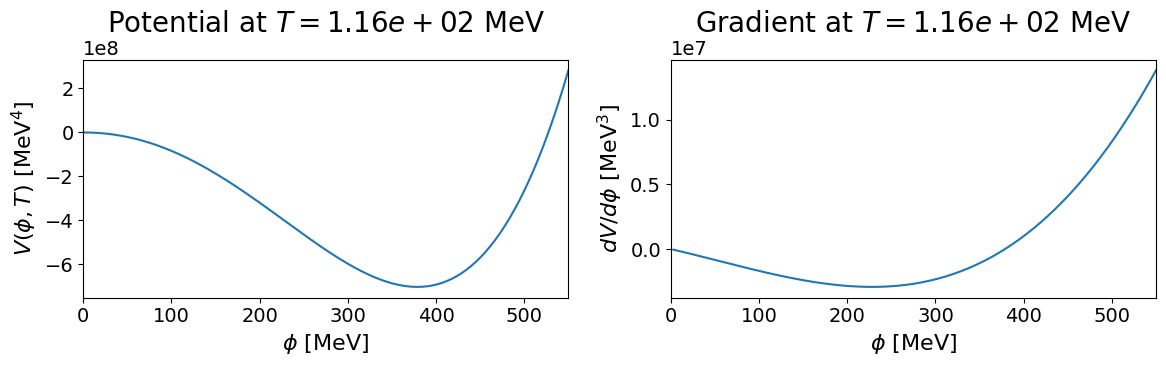

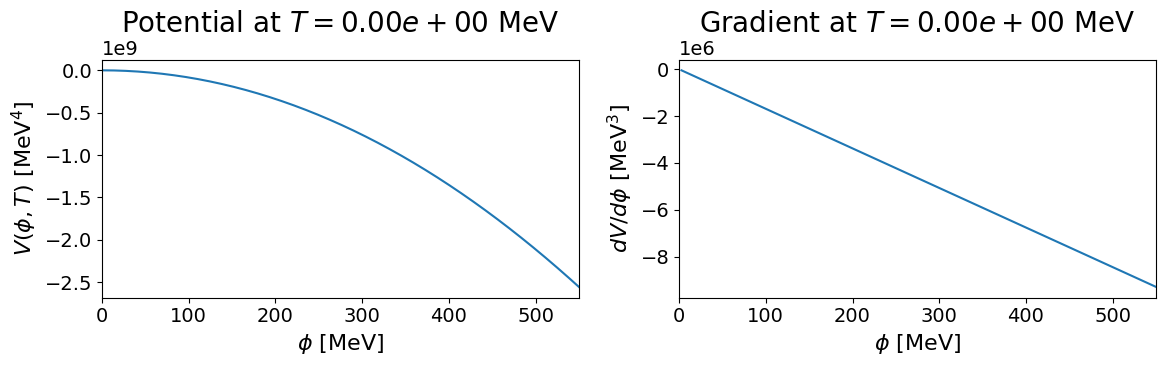

In [ ]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

# Set global font size parameters
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 20,
    'text.usetex': False    # <<< IMPORTANT for Colab
})

T = np.random.uniform(0, vev)

phi = np.linspace(0, 1.1 * vev, 200)
phi = phi.reshape(-1,1)

for t in [T, 0]:
    v = V(phi, t)
    dv = dV(phi, t)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(phi, v)
    axes[0].set_title(f"Potential at $T = {t:.2e}$ {units}")
    axes[0].set_xlabel(f"$\\phi$ [{units}]")
    axes[0].set_ylabel(f"$V(\\phi, T)$ [{units}$^4$]")

    axes[1].plot(phi[1:], dv[1:])
    axes[1].set_title(f"Gradient at $T = {t:.2e}$ {units}")
    axes[1].set_xlabel(f"$\\phi$ [{units}]")
    axes[1].set_ylabel(f"$dV/d\\phi$ [{units}$^3$]")

    for ax in axes:
        ax.set_xlim(phi[0], phi[-1])

    plt.tight_layout()
    plt.show()



In [ ]:
import importlib, sys

# Make sure both locations are on the path
sys.path.insert(0, "/content")
sys.path.insert(0, "/content/ELENA/src")

import utils
importlib.reload(utils)


<module 'utils' from '/content/ELENA/src/utils.py'>

In [ ]:
print("utils module path:", utils.__file__)
print("has s_SM?", hasattr(utils, "s_SM"))


utils module path: /content/ELENA/src/utils.py
has s_SM? True


In [ ]:
from potential_3d import V, dV
from temperatures import find_T_min, find_T_max, refine_Tmin
import numpy as np


/usr/local/lib/python3.12/dist-packages/cosmoTransitions/finiteT.py:88: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate.quad(f1, 0, abs(theta)**.5)[0]
